In [ ]:
import pandas as pd
import numpy as np
import numpy.linalg as lin
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import pickle

In [ ]:
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = '/content/drive/My Drive/Gait_Data___Arm_swing.csv'
data = pd.read_csv(filename)

In [ ]:
data

,PATNO,EVENT_ID,INFODT,COHORT,SP_U,RA_AMP_U,LA_AMP_U,RA_STD_U,LA_STD_U,SYM_U,R_JERK_U,L_JERK_U,ASA_U,ASYM_IND_U,TRA_U,T_AMP_U,CAD_U,STR_T_U,STR_CV_U,STEP_REG_U,STEP_SYM_U,JERK_T_U,SP__DT,RA_AMP_DT,LA_AMP_DT,RA_STD_DT,LA_STD_DT,SYM_DT,R_JERK_DT,L_JERK_DT,ASA_DT,ASYM_IND_DT,TRA_DT,T_AMP_DT,CAD_DT,STR_T_DT,STR_CV_DT,STEP_REG_DT,STEP_SYM_DT,JERK_T_DT,SW_VEL_OP,SW_PATH_OP,SW_FREQ_OP,SW_JERK_OP,SW_VEL_CL,SW_PATH_CL,SW_FREQ_CL,SW_JERK_CL,TUG1_DUR,TUG1_STEP_NUM,TUG1_STRAIGHT_DUR,TUG1_TURNS_DUR,TUG1_STEP_REG,TUG1_STEP_SYM,TUG2_DUR,TUG2_STEP_NUM,TUG2_STRAIGHT_DUR,TUG2_TURNS_DUR,TUG2_STEP_REG,TUG2_STEP_SYM
0,42443,V06,11/2018,1.0,1.445,42.787289,31.405978,2.783204,2.597315,0.369588,0.001618,0.002542,9.754631,15.460948,5.848241,1.515544,121.858032,2.086857,9.695562,0.895523,1.034529,0.308086,1.294,43.400615,28.585174,1.518266,2.730496,0.520676,0.001356,0.002647,12.948480,20.628904,8.854934,3.039683,110.765656,2.282169,9.107048,0.867668,1.128648,0.251367,0.002220,3.362521,0.606840,0.264631,0.001116,4.624927,0.911394,0.517390,10.679688,11.603516,0.554688,1.625000,0.612586,1.421568,10.390625,12.291016,0.546875,1.523438,0.565465,1.056312
1,42443,V04,11/2017,1.0,1.211,41.744432,42.194299,2.286481,2.235276,0.019062,0.002209,0.003016,0.612344,0.961927,4.495013,1.844470,124.932405,1.108796,18.204324,0.847616,1.096712,0.408350,1.083,40.461258,38.509009,2.889803,1.960981,0.094726,0.001300,0.003064,2.918529,4.589372,9.059862,1.318486,115.166740,2.127298,12.394186,0.821692,1.084477,0.238692,0.000739,3.987392,1.259718,0.352066,0.000491,4.656264,0.998160,0.579636,8.828125,10.854492,0.507812,1.312500,0.605626,1.284985,9.437500,11.674805,0.523438,1.441406,0.744995,1.209420
2,42438,V06,10/2018,3.0,1.131,30.357805,42.788477,5.422287,5.012269,0.289054,0.002742,0.008316,10.824114,17.230208,12.806257,3.555864,119.239701,1.709821,23.580869,0.171958,0.189310,0.079108,0.975,23.945266,54.069940,5.816408,3.961604,0.557285,0.001436,0.011285,23.498889,38.733138,17.197593,3.945442,108.706783,1.864720,20.781352,0.312550,0.436560,0.044208,0.002073,5.766604,0.921466,0.750949,0.002139,3.730654,0.297881,0.364307,15.398438,17.244141,0.593750,2.152344,0.741461,0.993754,13.781250,16.245117,0.554688,2.363281,0.713150,1.002639
3,42426,V06,12/2018,1.0,1.395,47.294965,34.610918,7.725009,7.838284,0.375873,0.003395,0.005928,9.854201,15.628248,12.864062,2.271845,115.152744,1.363281,17.422974,0.396836,0.455293,0.840399,1.374,50.526484,29.078187,9.154144,6.479747,0.796708,0.003321,0.004698,17.021137,27.560064,18.252199,2.924957,113.181701,2.063368,13.869136,0.796439,1.021863,0.753483,0.003168,3.488662,0.613927,0.268209,0.002861,2.600912,0.591471,0.151052,10.109375,10.029297,0.632812,1.804688,0.575304,1.137755,8.820312,8.132812,0.593750,1.500000,0.548270,3.290938
4,42426,BL,11/2016,1.0,0.982,51.516231,30.989870,7.412588,4.762775,0.672047,0.049690,0.059845,15.409553,24.756537,13.894265,5.489931,120.418284,1.167643,13.878575,0.506572,7.210779,0.759367,NaN,44.424253,29.342744,4.503914,4.267904,0.511943,0.028710,0.037304,12.664787,20.189786,17.450813,3.405127,104.749273,1.552649,18.687840,0.773912,1.215303,0.487108,0.001950,3.381051,0.610830,0.257746,0.002441,3.565628,0.669272,0.282145,8.875000,7.782227,0.632812,1.710938,0.509044,1.909214,8.609375,7.441406,0.640625,1.449219,0.667530,1.035053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,60046,V12,05/2019,NaN,NaN,23.160092,27.543798,3.630631,3.522706,0.158126,0.024499,0.020238,5.585177,8.818220,5.807278,3.115074,109.882244,1.037598,1.037638,0.720560,0.766814,0.315659,NaN,13.969031,26.566523,5.298619,11.184046,0.441246,0.023170,0.022440,18.009327,29.496778,5.279186,3.769693,60.853459,1.171875,2.207358,0.646497,0.732742,0.214303,0.000406,2.679020,1.624821,0.160248,0.000479,3.796451,1.324485,0.345953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
data = data.drop(['PATNO','EVENT_ID','INFODT'],axis = 1)

In [ ]:
data = data.drop(['SW_PATH_CL','STEP_REG_U','TUG1_STEP_NUM','TRA_U','STEP_SYM_U','R_JERK_DT'],axis = 1)

# label값이 nan인거 제거

In [ ]:
data = data.dropna(subset=['COHORT'])

# 결측치값 미리 제거

In [ ]:
data_drop_first = data.dropna(how='any') # 55 NaN data

In [ ]:
data_feature = data_drop_first.drop(['COHORT'],axis=1)
data_label = data_drop_first['COHORT']

In [ ]:
data_label_1 = np.asarray(data_label)
data_label = pd.DataFrame(data=data_label_1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_feature)
data_scaled_drop_first = scaler.transform(data_feature)
data_scaled_drop_first = pd.DataFrame(data = data_scaled_drop_first, columns = data_feature.columns)

In [ ]:
data_drop_first = pd.concat([data_label, data_scaled_drop_first],axis=1)

In [ ]:
data_drop_first.rename(columns={0:"COHORT"}, inplace=True)

# 결측치값 나중 제거


In [ ]:
def get_outlier(df = None, column = None, weight = 1.5):
  fraud = df[df['COHORT']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [ ]:
columns = list(data)
for i in range(1, len(columns) ,1):
  outlier_index = get_outlier(df = data, column = columns[i], weight=1.5)
  for j in range(1,len(outlier_index)+1, 1):
    data = data.replace(data[columns[i]][outlier_index[j-1]],np.NaN)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
imputer.fit(data)
imputer_num = imputer.transform(data)
data = pd.DataFrame(imputer_num, columns = data.columns)

In [ ]:
imputer.fit(data)
imputer_num2 = imputer.transform(data)
data = pd.DataFrame(imputer_num2, columns = data.columns)

In [ ]:
data = data.astype({'COHORT':'category'}) #나중에

In [ ]:
data_feature = data.drop(['COHORT'],axis=1)
data_label = data['COHORT']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_feature)
data_scaled = scaler.transform(data_feature)
data_scaled = pd.DataFrame(data = data_scaled, columns = data_feature.columns)
data = pd.concat([data_label, data_scaled],axis=1)

# 모델 훈련 및 테스트

In [ ]:
y_drop_first = data_drop_first[['COHORT']]
x_drop_first = data_drop_first.drop(columns=['COHORT'])
y = data[['COHORT']]
x = data.drop(columns=['COHORT'])

In [ ]:
from sklearn.model_selection import train_test_split

x_drop_first_train, x_drop_first_test, y_drop_first_train, y_drop_first_test = train_test_split(x_drop_first,y_drop_first, test_size = 0.1, random_state = 33)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 33)

# 결정트리 - data_drop_first

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [ ]:
#Find the most accurate value of k of max_depth
def max_depth(k):
  score = 0
  scroe_k = 0
  k_value = 0
  for i in range(1,k+1,1):
    globals()['max_depth_classifier_{}'.format(i+1)] = DecisionTreeClassifier(max_depth=i)
    globals()['max_depth_classifier_{}'.format(i+1)].fit(x_train, y_train)
    score_k = globals()['max_depth_classifier_{}'.format(i+1)].score(x_test, y_test)
    if score_k >= score:
      score = score_k
      k_value = i
  return k_value
best_max_depth = max_depth(100)

In [ ]:
#Find the most accurate value of k in max_leaf_nodes
def max_leaf_nodes(k):
  score = 0
  scroe_k = 0
  k_value = 0
  for i in range(2,k+1,1):
    globals()['max_leaf_classifier_{}'.format(i+1)] = DecisionTreeClassifier(max_leaf_nodes=i)
    globals()['max_leaf_classifier_{}'.format(i+1)].fit(x_train, y_train)
    score_k = globals()['max_depth_classifier_{}'.format(i+1)].score(x_test, y_test)
    if score_k >= score:
      score = score_k
      k_value = i
  return k_value
best_max_leaf_nodes = max_leaf_nodes(100)

In [ ]:
#Find the most accurate value of k in min_samples_split
def min_samples_split(k):
  score = 0
  scroe_k = 0
  k_value = 0
  for i in range(2,k+1,1):
    globals()['min_samples_split_classifier_{}'.format(i+1)] = DecisionTreeClassifier(min_samples_split=i)
    globals()['min_samples_split_classifier_{}'.format(i+1)].fit(x_train, y_train)
    score_k = globals()['min_samples_split_classifier_{}'.format(i+1)].score(x_test, y_test)
    if score_k >= score:
      score = score_k
      k_value = i
  return k_value
best_min_samples_split = min_samples_split(1000)

In [ ]:
#Find the most accurate value of k in min_impurity_decrease
def min_impurity_decrease(k):
  score = 0
  scroe_k = 0
  k_value = 0
  for i in np.arange(0,k,0.001):
    globals()['min_impurity_decrease_classifier_{}'.format(i+1)] = DecisionTreeClassifier(min_impurity_decrease=i)
    globals()['min_impurity_decrease_classifier_{}'.format(i+1)].fit(x_train, y_train)
    score_k = globals()['min_impurity_decrease_classifier_{}'.format(i+1)].score(x_test, y_test)
    if score_k >= score:
      score = score_k
      k_value = i
  return k_value
best_min_impurity_decrease = min_impurity_decrease(1)

In [ ]:
#Find the most accurate value of k in min_samples_leaf
def min_samples_leaf(k):
  score = 0
  scroe_k = 0
  k_value = 0
  for i in range(2,k+1,1):
    globals()['min_samples_leaf_classifier_{}'.format(i+1)] = DecisionTreeClassifier(min_samples_leaf=i)
    globals()['min_samples_leaf_classifier_{}'.format(i+1)].fit(x_train, y_train)
    score_k = globals()['min_samples_leaf_classifier_{}'.format(i+1)].score(x_test, y_test)
    if score_k >= score:
      score = score_k
      k_value = i
  return k_value
best_min_samples_leaf = min_samples_leaf(1000)

In [ ]:
def best_decision_model(x, y, x_test, y_test, best_max_depth, best_max_leaf_nodes, best_min_samples_split, best_min_impurity_decrease, best_min_samples_leaf):
  score = np.zeros(5)
  max = 0
  max_score_model = 0
  classifier_0 = DecisionTreeClassifier(max_depth = best_max_depth)
  classifier_0.fit(x_train, y_train)
  score[0] = np.mean(cross_val_score(classifier_0, x, y, scoring = 'accuracy', cv = 10))
  classifier_1 = DecisionTreeClassifier(max_leaf_nodes = best_max_leaf_nodes)
  classifier_1.fit(x_train, y_train)
  score[1] = np.mean(cross_val_score(classifier_1, x, y, scoring = 'accuracy', cv = 10))
  classifier_2 = DecisionTreeClassifier(min_samples_split = best_min_samples_split)
  classifier_2.fit(x_train, y_train)
  score[2] = np.mean(cross_val_score(classifier_2, x, y, scoring = 'accuracy', cv = 10))
  classifier_3 = DecisionTreeClassifier(min_impurity_decrease = best_min_impurity_decrease)
  classifier_3.fit(x_train, y_train)
  score[3] = np.mean(cross_val_score(classifier_3, x, y, scoring = 'accuracy', cv = 10))
  classifier_4 = DecisionTreeClassifier(min_samples_leaf = best_min_samples_leaf)
  classifier_4.fit(x_train, y_train)
  score[4] = np.mean(cross_val_score(classifier_4, x, y, scoring = 'accuracy', cv = 10))
  for i in range(0,4,1):
    if max <= score[i]:
      max = score[i]
      max_score_model = i
  if max_score_model == 0:
    return classifier_0
  if max_score_model == 1:
    return classifier_1
  if max_score_model == 2:
    return classifier_2
  if max_score_model == 3:
    return classifier_3
  if max_score_model == 4:
    return classifier_4

In [ ]:
drop_first_dt = best_decision_model(x_drop_first, y_drop_first, x_drop_first_test, y_drop_first_test, best_max_depth, best_max_leaf_nodes, best_min_samples_split, best_min_impurity_decrease, best_min_samples_leaf)
drop_first_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
drop_first_dt = DecisionTreeClassifier(max_leaf_nodes = 9)
drop_first_dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
drop_first_dt_score = cross_val_score(drop_first_dt,x_drop_first,y_drop_first, cv=10)
drop_first_dt_score = drop_first_dt_score.mean()
drop_first_dt_score

0.7525641025641027

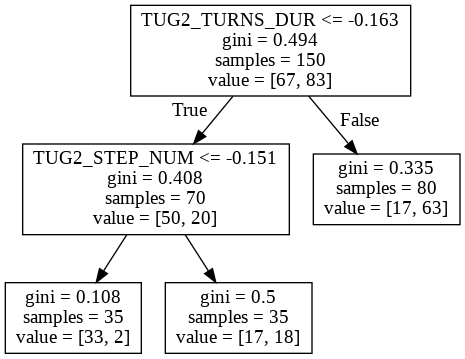

In [ ]:
# 아래 코드는 classifier 결정트리를 시각화한다.
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(drop_first_dt, feature_names=x_drop_first_train.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

In [ ]:
y_pred = drop_first_dt.predict(x_drop_first_test)
y_prob = drop_first_dt.predict_proba(x_drop_first_test)[:,1]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_drop_first_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.50      0.83      0.62         6
         3.0       0.67      0.29      0.40         7

    accuracy                           0.54        13
   macro avg       0.58      0.56      0.51        13
weighted avg       0.59      0.54      0.50        13



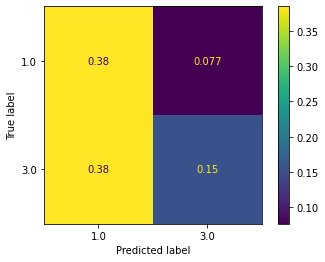

In [ ]:
# TODO: confusion matrix를 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(drop_first_dt, x_drop_first_test, y_drop_first_test, normalize = 'all')

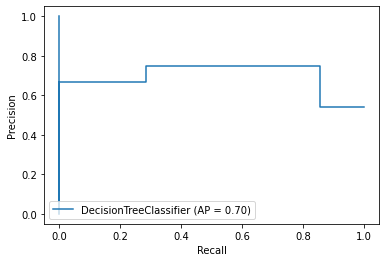

In [ ]:
# TODO: precision_recall curve를 시각화
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(drop_first_dt, x_drop_first_test, y_drop_first_test)

In [ ]:
from sklearn.metrics import roc_auc_score

drop_first_dt_auc = roc_auc_score(y_drop_first_test, y_prob)
print(drop_first_dt_auc)

0.7023809523809524


# 결정트리 - data

In [ ]:
data_dt = best_decision_model(x, y, x_test, y_test, best_max_depth, best_max_leaf_nodes, best_min_samples_split, best_min_impurity_decrease, best_min_samples_leaf)
data_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
data_dt_score = cross_val_score(data_dt,x,y, cv=10)
data_dt_score = data_dt_score.mean()
data_dt_score

0.7238970588235294

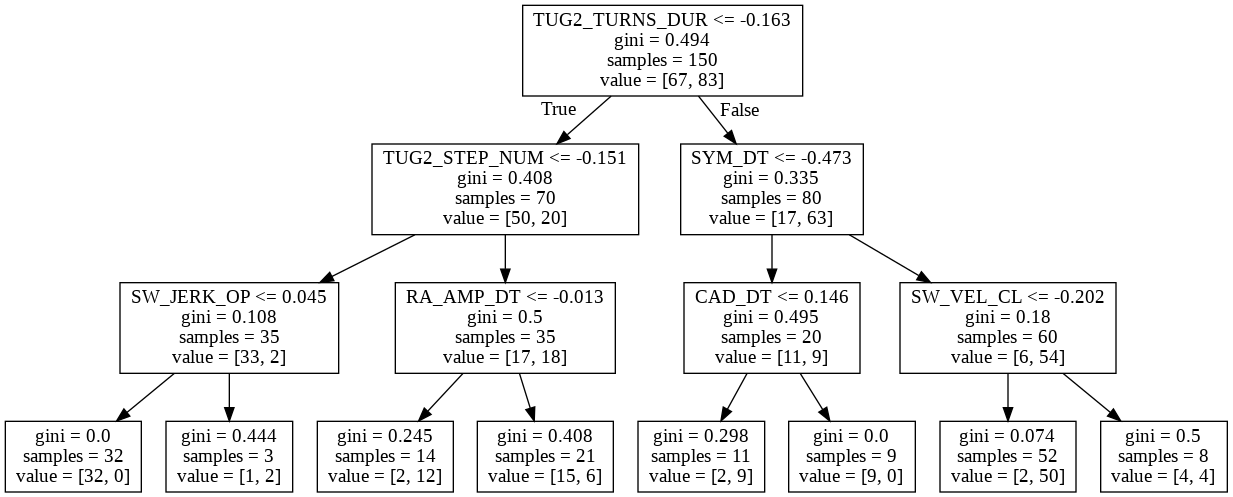

In [ ]:
# 아래 코드는 classifier 결정트리를 시각화한다.
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(data_dt, feature_names=x_train.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

In [ ]:
y_pred = data_dt.predict(x_test)
y_prob = data_dt.predict_proba(x_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.83      0.71      0.77         7
         3.0       0.82      0.90      0.86        10

    accuracy                           0.82        17
   macro avg       0.83      0.81      0.81        17
weighted avg       0.82      0.82      0.82        17



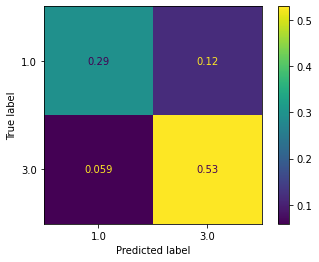

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(data_dt, x_test, y_test, normalize = 'all')

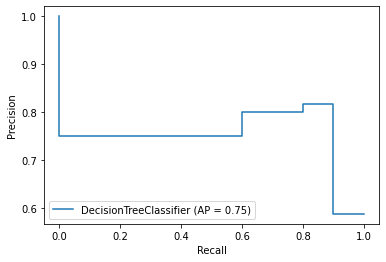

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(data_dt, x_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

data_dt_auc = roc_auc_score(y_test, y_prob)
data_dt_auc
print(data_dt_auc)

0.7910714285742871


# randomforest - data_drop_first

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
rfc =  RandomForestClassifier()
rf_param_grid = {
    'n_estimators' :[5,10,50,100,200],
    'max_depth' : [3,4,5,6,8,10],
    'min_samples_leaf' : [3,4,5,6,7,8,10],
    'min_samples_split' : [5,6,7,8,9,10]
}

In [ ]:
rf_grid =GridSearchCV(rfc, param_grid = rf_param_grid,scoring='roc_auc',n_jobs = -1, verbose=1)
rf_grid.fit(x_drop_first_train, y_drop_first_train)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed: 10.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
best_param = rf_grid.best_params_
best_param

{'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 100}

In [ ]:
rfc_drop_first = RandomForestClassifier(max_depth= 3,
 min_samples_leaf= 3,
 min_samples_split= 9,
 n_estimators= 100,
 random_state = 42)
rfc_drop_first.fit(x_drop_first_train, y_drop_first_train)
prediction = rfc_drop_first.predict(x_drop_first_test)
rfc_drop_first_score = cross_val_score(rfc_drop_first,x_drop_first_train,y_drop_first_train, cv=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

In [ ]:
drop_first_rfc_score = rfc_drop_first_score.mean()
drop_first_rfc_score

0.7584980237154151

In [ ]:
y_pred = rfc_drop_first.predict(x_drop_first_test)
y_prob = rfc_drop_first.predict_proba(x_drop_first_test)[:,1]

In [ ]:
print(classification_report(y_drop_first_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.57      0.67      0.62         6
         3.0       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13



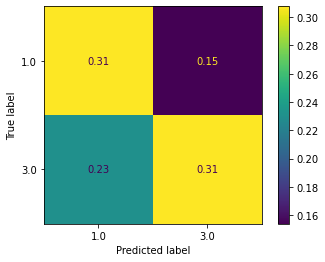

In [ ]:
# TODO: confusion matrix를 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc_drop_first, x_drop_first_test, y_drop_first_test, normalize = 'all')

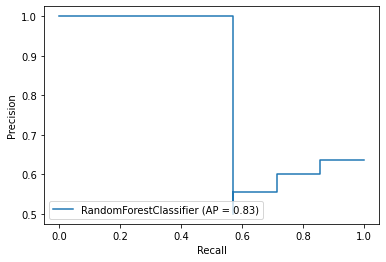

In [ ]:
# TODO: precision_recall curve를 시각화
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(rfc_drop_first, x_drop_first_test, y_drop_first_test)

In [ ]:
from sklearn.metrics import roc_auc_score

drop_first_rfc_auc = roc_auc_score(y_drop_first_test, y_prob)
print(drop_first_rfc_auc)

0.7142857142857143


# randomforest - data

In [ ]:
rfc =  RandomForestClassifier()
rf_param_grid = {
    'n_estimators' :[1,5,10,50,100],
    'max_depth' : [3,4,5,6,8,10,12],
    'min_samples_leaf' : [3,4,5,6,7,8,10],
    'min_samples_split' : [3,5,6,7,8,9,10]
}

In [ ]:
rf_grid =GridSearchCV(rfc, param_grid = rf_param_grid,scoring='accuracy',n_jobs = -1, verbose=1)
rf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 1715 candidates, totalling 8575 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3836 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6036 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 8575 out of 8575 | elapsed:  6.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
best_param = rf_grid.best_params_
best_param

In [ ]:
rfc_data = RandomForestClassifier(max_depth= 6,
 min_samples_leaf= 3,
 min_samples_split= 8,
 n_estimators= 10,
 random_state = 42)
rfc_data.fit(x_train, y_train)
rfc_score = cross_val_score(rfc_data,x_train,y_train, cv=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

In [ ]:
rfc_score = rfc_score.mean()
rfc_score

0.7533333333333333

In [ ]:
y_pred = rfc_data.predict(x_test)
y_prob = rfc_data.predict_proba(x_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.55      0.86      0.67         7
         3.0       0.83      0.50      0.62        10

    accuracy                           0.65        17
   macro avg       0.69      0.68      0.65        17
weighted avg       0.71      0.65      0.64        17



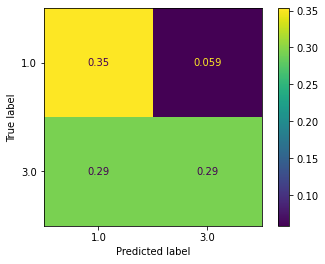

In [ ]:
# TODO: confusion matrix를 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc_data, x_test, y_test, normalize = 'all')

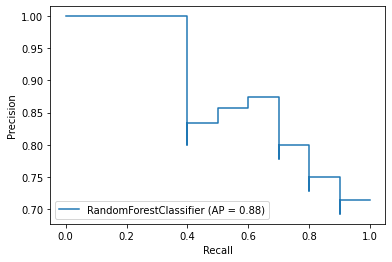

In [ ]:
# TODO: precision_recall curve를 시각화
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(rfc_data, x_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

data_rfc_auc = roc_auc_score(y_test, y_prob)
print(data_rfc_auc)

0.8285714285714285


# knn - data_drop_first

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Data

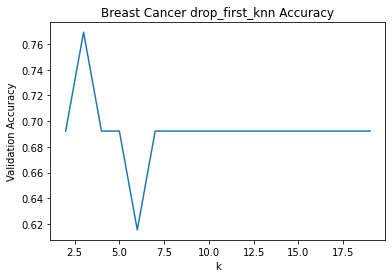

0.7692307692307693 3


In [ ]:
import matplotlib.pyplot as plt
k_list = range(2,20)
drop_first_knn_score = 0
accuracies = []
for k in k_list:
  drop_first_knn = KNeighborsClassifier(n_neighbors = k)
  drop_first_knn.fit(x_drop_first, y_drop_first)
  accuracies.append(drop_first_knn.score(x_drop_first_test, y_drop_first_test))
  if drop_first_knn.score(x_drop_first_test, y_drop_first_test) >= drop_first_knn_score:
    drop_first_knn_score = drop_first_knn.score(x_drop_first_test, y_drop_first_test)
    drop_first_knn_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Breast Cancer drop_first_knn Accuracy")
plt.show()
print(drop_first_knn_score, drop_first_knn_k)

In [ ]:
drop_first_knn = KNeighborsClassifier(n_neighbors = 4)
drop_first_knn.fit(x_drop_first_train, y_drop_first_train)
drop_first_knn_score = cross_val_score(drop_first_knn,x_drop_first_train,y_drop_first_train, cv=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

In [ ]:
drop_first_knn_score = drop_first_knn_score.mean()
drop_first_knn_score

0.706060606060606

In [ ]:
y_pred = drop_first_knn.predict(x_drop_first_test)
y_prob = drop_first_knn.predict_proba(x_drop_first_test)[:,1]

In [ ]:
print(classification_report(y_drop_first_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.83      0.71         6
         3.0       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



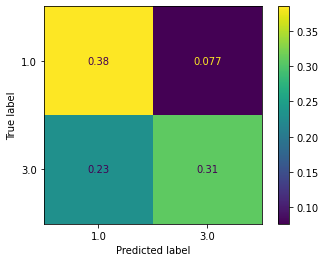

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(drop_first_knn, x_drop_first_test, y_drop_first_test, normalize = 'all')

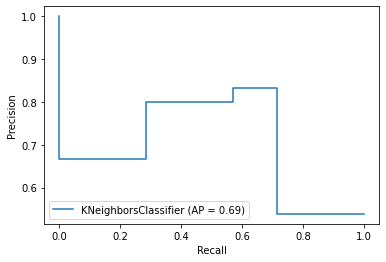

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(drop_first_knn, x_drop_first_test, y_drop_first_test)

In [ ]:
from sklearn.metrics import roc_auc_score

first_drop_knn_auc = roc_auc_score(y_drop_first_test, y_prob)
first_drop_knn_auc

# knn - data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Data

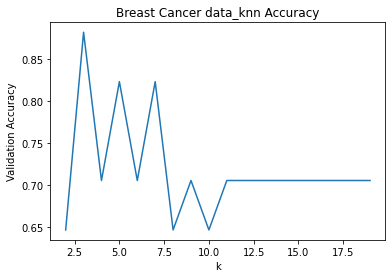

0.8823529411764706 3


In [ ]:
import matplotlib.pyplot as plt
k_list = range(2,20)
data_knn_score = 0
accuracies = []
for k in k_list:
  data_knn = KNeighborsClassifier(n_neighbors = k)
  data_knn.fit(x, y)
  accuracies.append(data_knn.score(x_test, y_test))
  if data_knn.score(x_test, y_test) >= data_knn_score:
    data_knn_score = data_knn.score(x_test, y_test)
    data_knn_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Breast Cancer data_knn Accuracy")
plt.show()
print(data_knn_score, data_knn_k)

In [ ]:
data_knn = KNeighborsClassifier(n_neighbors = 4)
data_knn.fit(x_train, y_train)
data_knn_score = cross_val_score(data_knn,x_train,y_train, cv=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

In [ ]:
data_knn_score = data_knn_score.mean()
data_knn_score

0.64

In [ ]:
y_pred = data_knn.predict(x_test)
y_prob = data_knn.predict_proba(x_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.83      0.71      0.77         7
         3.0       0.82      0.90      0.86        10

    accuracy                           0.82        17
   macro avg       0.83      0.81      0.81        17
weighted avg       0.82      0.82      0.82        17



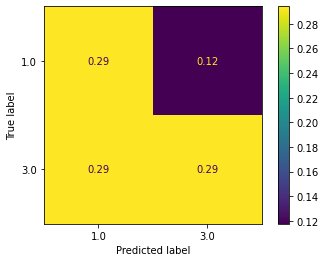

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(data_knn, x_test, y_test, normalize = 'all')

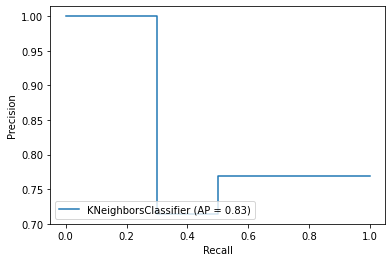

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(data_knn, x_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

data_knn_auc = roc_auc_score(y_test, y_prob)
data_knn_auc

0.7857142857142857

# svm - data_drop_first

In [ ]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
 
drop_first_svm =svm.SVC(kernel = 'linear')

# 교차검증

drop_first_svm_score = cross_val_score(drop_first_svm, x_drop_first, y_drop_first, cv = 10)
drop_first_svm_score

pd.DataFrame(cross_validate(drop_first_svm, x_drop_first, y_drop_first, cv =10))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,fit_time,score_time,test_score
0,0.004936,0.001482,0.846154
1,0.007891,0.001912,0.615385
2,0.005277,0.001602,0.307692
3,0.005466,0.001956,0.692308
4,0.008941,0.001468,0.538462
5,0.004889,0.001496,0.583333
6,0.006321,0.001379,0.666667
7,0.007433,0.001413,0.583333
8,0.005033,0.001198,0.833333
9,0.005543,0.001215,0.500000


In [ ]:
drop_first_svm_score = drop_first_svm_score.mean()
drop_first_svm_score

0.6166666666666667

In [ ]:
# SVM, kernel = 'rbf'로 비선형분리 진행
 
drop_first_svm =svm.SVC(kernel = 'rbf')

# 교차검증

drop_first_svm_score = cross_val_score(drop_first_svm, x_drop_first, y_drop_first, cv = 10)
drop_first_svm_score

pd.DataFrame(cross_validate(drop_first_svm, x_drop_first, y_drop_first, cv =5))


In [ ]:
drop_first_svm_score = drop_first_svm_score.mean()
drop_first_svm_score

0.7288461538461538

In [ ]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=100,probability = True)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_drop_first, y_drop_first)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,C,mean_test_score
1,0.010,0.728
2,0.100,0.688
3,1.000,0.616
7,100.000,0.592
0,0.001,0.584
4,10.000,0.584
5,25.000,0.584
6,50.000,0.584


In [ ]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

drop_first_svm = svm.SVC(kernel = 'rbf',random_state=100)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

drop_first_svm = GridSearchCV(drop_first_svm,
                      param_grid = parameters, cv = 10)

drop_first_svm.fit(x_drop_first_train, y_drop_first_train)

result = pd.DataFrame(drop_first_svm.cv_results_['params'])
result['mean_test_score'] = drop_first_svm.cv_results_['mean_test_score']

In [ ]:
result.sort_values(by='mean_test_score', ascending=False)

In [ ]:
drop_first_svm =svm.SVC(kernel = 'rbf',C=5, gamma=0.01,probability = True)
drop_first_svm.fit(x_drop_first_train, y_drop_first_train)
drop_first_svm_score = cross_val_score(drop_first_svm, x_drop_first_train, y_drop_first_train, cv = 10)
drop_first_svm_score

pd.DataFrame(cross_validate(drop_first_svm, x_drop_first_train, y_drop_first_train, cv =10))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,fit_time,score_time,test_score
0,0.008394,0.001371,0.750000
1,0.008330,0.001348,0.583333
2,0.008262,0.001395,0.636364
3,0.008500,0.001630,0.636364
4,0.009074,0.001658,0.727273
5,0.009060,0.001616,0.727273
6,0.009154,0.002090,0.636364
7,0.009138,0.001316,0.545455
8,0.008493,0.001453,0.909091
9,0.008452,0.001765,0.727273


In [ ]:
drop_first_svm_score = drop_first_svm_score.mean()
drop_first_svm_score

0.6878787878787879

In [ ]:
y_pred = drop_first_svm.predict(x_drop_first_test)
y_prob = drop_first_svm.predict_proba(x_drop_first_test)[:,1]

In [ ]:
print(classification_report(y_drop_first_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.83      0.71         6
         3.0       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



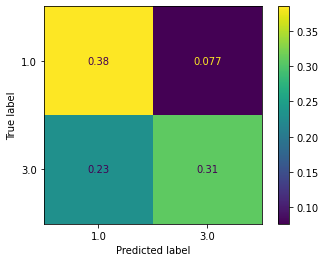

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(drop_first_svm, x_drop_first_test, y_drop_first_test, normalize = 'all')

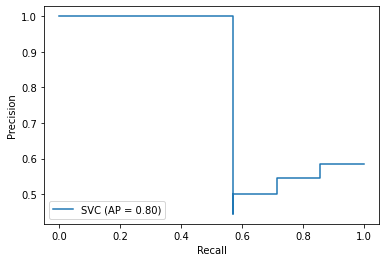

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(drop_first_svm, x_drop_first_test, y_drop_first_test)

In [ ]:
from sklearn.metrics import roc_auc_score

first_drop_svm_auc = roc_auc_score(y_drop_first_test, y_prob)
first_drop_svm_auc

0.7380952380952381

# svm - data

In [ ]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
 
data_svm =svm.SVC(kernel = 'linear')

# 교차검증

data_svm_score = cross_val_score(data_svm, x, y, cv = 5)
data_svm_score

pd.DataFrame(cross_validate(data_svm, x, y, cv =5))

In [ ]:
data_svm_score = data_svm_score.mean()
data_svm_score

0.6169340463458111

In [ ]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

data_svm = svm.SVC(kernel = 'rbf',random_state=100)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

data_svm = GridSearchCV(data_svm,
                      param_grid = parameters, cv = 10)

data_svm.fit(x_train, y_train)

result = pd.DataFrame(data_svm.cv_results_['params'])
result['mean_test_score'] = data_svm.cv_results_['mean_test_score']

In [ ]:
result.sort_values(by='mean_test_score', ascending=False)

In [ ]:
data_svm =svm.SVC(kernel = 'rbf',C=1, gamma=0.03,probability = True)
data_svm.fit(x_train, y_train)
data_svm_score = cross_val_score(data_svm, x_train, y_train, cv = 10)
data_svm_score

pd.DataFrame(cross_validate(data_svm, x_train, y_train, cv =10))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,fit_time,score_time,test_score
0,0.014160,0.002059,0.800000
1,0.014310,0.001744,0.800000
2,0.013358,0.001943,0.733333
3,0.013721,0.001723,0.666667
4,0.012657,0.001713,0.866667
5,0.012765,0.001727,0.800000
6,0.013247,0.001943,0.733333
7,0.013981,0.001718,0.800000
8,0.014593,0.001926,0.800000
9,0.015577,0.001787,0.733333


In [ ]:
data_svm_score = data_svm_score.mean()
data_svm_score

0.7733333333333333

In [ ]:
y_pred = data_svm.predict(x_test)
y_prob = data_svm.predict_proba(x_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.67      0.86      0.75         7
         3.0       0.88      0.70      0.78        10

    accuracy                           0.76        17
   macro avg       0.77      0.78      0.76        17
weighted avg       0.79      0.76      0.77        17



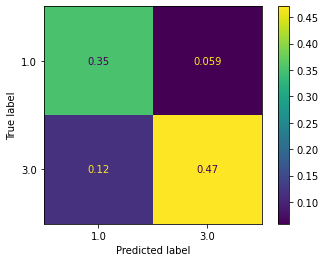

In [ ]:
# TODO: confusion matrix를 시각화
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(data_svm, x_test, y_test, normalize = 'all')

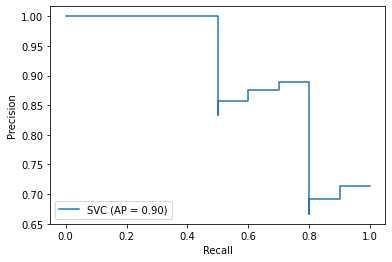

In [ ]:
# TODO: precision_recall curve를 시각화
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(data_svm, x_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

data_svm_auc = roc_auc_score(y_test, y_prob)
print(data_svm_auc)

0.8142857142857143


# XGBoost - data_first_drop

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import plot_importance
from xgboost import XGBClassifier

In [ ]:
xgb=XGBClassifier()

In [ ]:
xgb_param_grid = {'n_estimators' : [1,10,20,50,100,200],
                  'learning_rate' : [0.01,0.02,0.03,0.05,0.1,0.15,0.2],
                  'max_depth' : [2,3,4]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='accuracy',n_jobs=-1,verbose=1)
xgb_grid.fit(x_drop_first_train, y_drop_first_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:   15.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15,
                                           0.2],
                         'max_depth': [2, 3, 4],


In [ ]:
first_drop_xgb_df = pd.DataFrame(xgb_grid.cv_results_)
first_drop_xgb_df.sort_values(by=['rank_test_score'], inplace=True)
pd.set_option('display.max_colwidth', -1)


NameError: ignored

In [ ]:
first_drop_xgb_df[['params','mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
91,"{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 10}",0.802767,1
57,"{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}",0.802767,1
39,"{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 50}",0.802372,3
38,"{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 20}",0.793676,4
92,"{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 20}",0.793676,4


In [ ]:
first_drop_xgb = XGBClassifier(n_estimators=10, learning_rate=0.15,max_depth=2, random_state=42)
first_drop_xgb.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
first_drop_xgb_score = cross_val_score(first_drop_xgb,x_drop_first,y_drop_first, cv=10)
first_drop_xgb_score = first_drop_xgb_score.mean()
first_drop_xgb_score

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7448717948717949

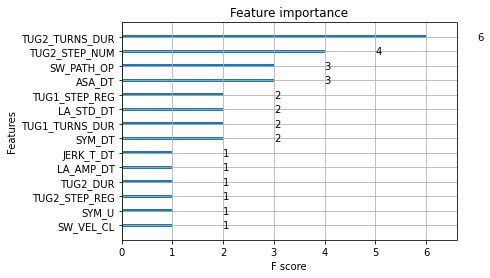

In [ ]:
fig,ax = plt.subplots()
plot_importance(first_drop_xgb, ax=ax)

In [ ]:
y_pred = first_drop_xgb.predict(x_drop_first_test)
y_prob = first_drop_xgb.predict_proba(x_drop_first_test)[:,1]

In [ ]:
print(classification_report(y_drop_first_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.83      0.71         6
         3.0       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



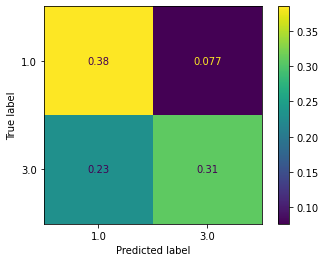

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(first_drop_xgb, x_drop_first_test, y_drop_first_test, normalize = 'all')

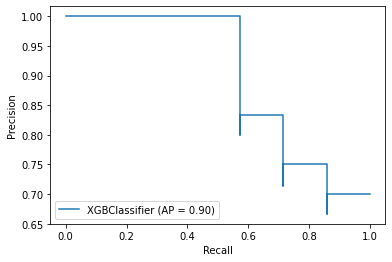

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(first_drop_xgb, x_drop_first_test, y_drop_first_test)

In [ ]:
from sklearn.metrics import roc_auc_score

first_drop_xgb_auc = roc_auc_score(y_drop_first_test, y_prob)
first_drop_xgb_auc

0.8571428571428572

# XGBoost - data

In [ ]:
xgb_param_grid = {'n_estimators' : [1,10,20,50,100,200],
                  'learning_rate' : [0.01,0.02,0.03,0.05,0.1,0.15,0.2],
                  'max_depth' : [2,3,4]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='accuracy',n_jobs=-1,verbose=1)
xgb_grid.fit(x_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:   21.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15,
                                           0.2],
                         'max_depth': [2, 3, 4],


In [ ]:
data_xgb_df = pd.DataFrame(xgb_grid.cv_results_)
data_xgb_df.sort_values(by=['rank_test_score'], inplace=True)
pd.set_option('display.max_colwidth', -1)
data_xgb_df[['params','mean_test_score', 'rank_test_score']].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,params,mean_test_score,rank_test_score
9,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}",0.753333,1
93,"{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50}",0.753333,2
61,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10}",0.746667,3
122,"{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20}",0.746667,4
41,"{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 200}",0.740000,5


In [ ]:
data_xgb = XGBClassifier(n_estimators=50, learning_rate=0.3,max_depth=3,random_state=42)
data_xgb.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
data_xgb_score = data_xgb.score(x_test, y_test)
print(data_xgb_score)

0.7647058823529411


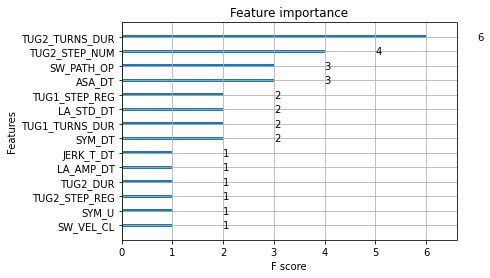

In [ ]:
fig,ax = plt.subplots()
plot_importance(first_drop_xgb, ax=ax)

In [ ]:
y_pred = data_xgb.predict(x_test)
y_prob = data_xgb.predict_proba(x_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.75      0.86      0.80         7
         3.0       0.89      0.80      0.84        10

    accuracy                           0.82        17
   macro avg       0.82      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



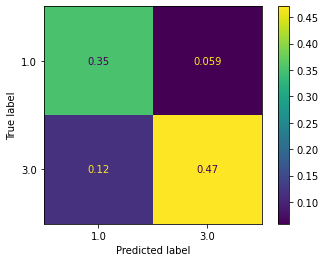

In [ ]:
# TODO: confusion matrix를 시각화한다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(data_xgb, x_test, y_test, normalize = 'all')

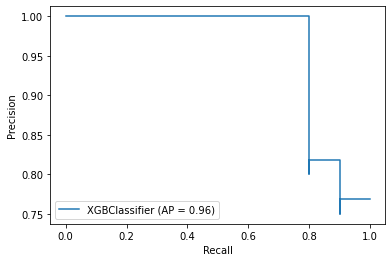

In [ ]:
# TODO: precision_recall curve를 시각화한다.
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(data_xgb, x_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

data_xgb_auc = roc_auc_score(y_test, y_prob)
data_xgb_auc

0.8857142857142858

# score 비교

In [ ]:
final_score = {'drop_first_dt_auc': [drop_first_dt_auc],
            'data_dt_auc': [data_dt_auc],
            'drop_first_rfc_auc': [drop_first_rfc_auc],
            'data_rfc_auc':[data_rfc_auc],
            'drop_first_knn_auc':[first_drop_knn_auc],
            'data_knn_auc':[data_knn_auc],
            'drop_first_svm_auc':[first_drop_svm_auc],
            'data_svm_auc':[data_svm_auc],
            'drop_first_xgb_auc':[first_drop_xgb_auc],
            'data_xgb_auc':[data_xgb_auc]}

In [ ]:
final_score = pd.DataFrame.from_dict(final_score,orient = 'index',columns=['roc_auc_score'])

In [ ]:
final_score.sort_values(by=['roc_auc_score'],ascending=False)

,roc_auc_score
data_xgb_auc,0.885714
drop_first_xgb_auc,0.857143
data_rfc_auc,0.828571
data_svm_auc,0.814286
data_dt_auc,0.791071
data_knn_auc,0.785714
drop_first_svm_auc,0.738095
drop_first_rfc_auc,0.714286
drop_first_dt_auc,0.702381
drop_first_knn_auc,0.700872


In [ ]:
final_score_2 = {'drop_first_dt_auc': [drop_first_dt_score],
            'data_dt_auc': [data_dt_score],
            'drop_first_rfc_auc': [drop_first_rfc_score],
            'data_rfc_auc':[rfc_score],
            'drop_first_knn_auc':[drop_first_knn_score],
            'data_knn_auc':[data_knn_score],
            'drop_first_svm_auc':[drop_first_svm_score],
            'data_svm_auc':[data_svm_score],
            'drop_first_xgb_auc':[first_drop_xgb_score],
            'data_xgb_auc':[data_xgb_score]}

In [ ]:
final_score_2 = pd.DataFrame.from_dict(final_score_2,orient = 'index',columns=['accuracy'])

In [ ]:
final_score_2.sort_values(by=['accuracy'],ascending=False)

,accuracy
drop_first_dt_auc,0.782692
data_svm_auc,0.773333
data_xgb_auc,0.764706
drop_first_rfc_auc,0.759684
data_rfc_auc,0.753333
drop_first_xgb_auc,0.744872
data_dt_auc,0.718015
drop_first_knn_auc,0.706061
drop_first_svm_auc,0.687879
data_knn_auc,0.640000
